In [44]:
#import required libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LinearSegmentedColormap, Normalize, ListedColormap, BoundaryNorm
from matplotlib import cm
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.linear_model import LinearRegression
from shapely import geometry
from descartes import PolygonPatch

In [45]:
#run notebook to define regional boundaries
%run region_boundaries.ipynb

In [109]:
def plot_prov_ax(prov, ax):

    """
    plot borders of a province on a given axis

    prov: list of strings of provincial abbreviations; ['AB'], ['BC'], ['AB','BC'], etc; prov = 'all' will plot all provincial/territorial borders
    ax: axis on which to plot the provincial borders

    Examples:

    fig, ax = plt.subplots()
    plot_prov_ax(prov = ['BC', 'AB', 'SK'], ax = ax) #plots British Colubmia, Alberta, and Saskatchewan

    fig, ax = plt.subplots()
    plot_prov_ax(prov = 'all', ax = ax) #plots all provincial/territorial borders
    """
    
    #load shapefile of provincial boundaries
    provshapes_filename = './Data/PROVINCE.SHP'
    provshapes = gpd.read_file(provshapes_filename)

    #create list of all prov/territorial abbreviations
    prov_abbreviations = [
                        'AB',
                        'SK',
                        'MB',
                        'NL',
                        'PE',
                        'NS',
                        'NT',
                        'NU',
                        'ON',
                        'NB',
                        'YT',
                        'BC',
                        'QC'
                      ]
    
    #if wanting to plot all borders
    if prov == 'all':
        prov = prov_abbreviations

    #loop through each input province/territory and plot borders
    for pv in prov:

        #polygons of this province/territory
        prov_poly = provshapes['geometry'][prov_abbreviations.index(pv)]

        #some jurisdictions have multiple polygones from lakes/islands/etc (e.g. BC)
        if len(np.shape(prov_poly)) == 0: #if only one polygon to plot

          lonBorder,latBorder = prov_poly.exterior.coords.xy 
          ax.plot(lonBorder,latBorder,'k')

        else: #if multiply polygons in shape to plot

          for ind in range(len(prov_poly)): 
            lonBorder_segment,latBorder_segment = prov_poly[ind].exterior.coords.xy 
            ax.plot(lonBorder_segment,latBorder_segment,'k')

In [111]:
# define rgbs for plotting -- chosen from coolors.co

#categorical w/ 3 categories
rgbs3 = np.array([
    [239, 121, 138],
    [176, 218, 241],
    [97, 63, 117]
]) / 256

#categorical w/ 4 categories
rgbs4 = np.array([
    [73, 71, 91],
    [86, 142, 163],
    [104, 195, 212],
    [242, 209, 201]
]) / 256

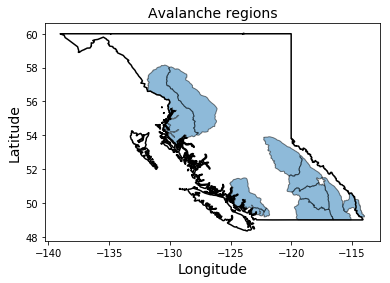

In [112]:
saveIt = 0

fs = 14

fig = plt.figure() 
ax = fig.gca() 
for poly in region_polys:
    ax.add_patch(PolygonPatch(poly, alpha = 0.5))
    
ax.set_xlabel('Longitude', fontsize = fs)
ax.set_ylabel('Latitude', fontsize = fs)
ax.set_title('Avalanche regions', fontsize = fs)

plot_prov_ax(prov = ['BC'], ax = ax)

if saveIt:
    plt.savefig('./Figures/regions.png', bbox_inches = 'tight', dpi = 300)
    
plt.show()

In [113]:
#investigate what the data looks like for one region

dataPath = './Data/'

regions = [
    'cariboos',
    'kananaskis',
    'kootenay-boundary',
    'lizard-range',
    'north-columbia',
    'north-rockies',
    'northwest-coastal',
    'northwest-inland',
    'purcells',
    'sea-to-sky',
    'south-coast',
    'south-columbia',
    'south-rockies',
    'yukon'    
          ]

region = regions[-5]
filename = region + '_Jan_to_Apr_2012_to_2017.csv'

data = pd.read_csv(dataPath + filename, parse_dates = True, index_col = 'Unnamed: 0')
data['Year'] = data.index.year
data['Month'] = data.index.month
data.head()

,Below Treeline,Treeline,Above Treeline,Year,Month
2012-01-01,2,3,3,2012,1
2012-01-02,2,3,3,2012,1
2012-01-03,2,4,4,2012,1
2012-01-04,3,4,4,2012,1
2012-01-05,2,3,4,2012,1


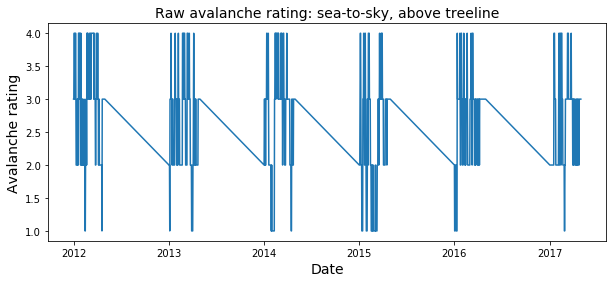

In [51]:
plt.figure(figsize = (10,4))
plt.plot(data['Above Treeline'])
plt.xlabel('Date', fontsize = fs)
plt.ylabel('Avalanche rating', fontsize = fs)
plt.title('Raw avalanche rating: ' + region + ', above treeline', fontsize = fs)
plt.show()

In [52]:
data_columns = ['Below Treeline', 'Treeline', 'Above Treeline']
data_7d = data[data_columns].rolling(7, center = True).mean() #7-day rolling average

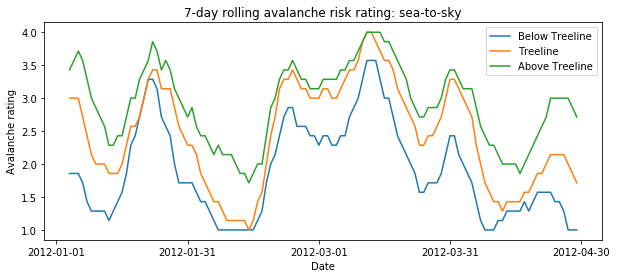

In [53]:
saveIt = 0

start = 0
end = 120

fig, ax = plt.subplots(figsize = (10,4))
ax.plot(data_7d[data_columns].iloc[start:end])
xticks = [ax.get_xticks()[0] + 30*ii for ii in range(5)]
ax.set_xticks(xticks)
ax.set_xlabel('Date')
ax.set_ylabel('Avalanche rating')
ax.set_title('7-day rolling avalanche risk rating: ' + region)
ax.legend(data_columns)

if saveIt:
    plt.savefig('./Figures/7day_rolling_risk.png', bbox_inches = 'tight', dpi = 300)

plt.show()

In [54]:
#identify how much data is missing in each region

N_missing_threshold = 40
goodInds = []
all_data = []

for kk, region in enumerate(regions):
    
    dataPath = '/Users/samanderson/repos/avalanche/avalanche_data/'
    filename = region + '_Jan_to_Apr_2012_to_2017.csv'

    data = pd.read_csv(dataPath + filename, parse_dates = True, index_col = 'Unnamed: 0')
    data['Year'] = data.index.year
    data['Month'] = data.index.month
    
    N_missing = data['Treeline'].isna().sum()
    if N_missing <= N_missing_threshold:
        goodInds.append(kk)
        all_data.append(data)
    print('Missing days in ' + region + ': ' + str(N_missing))
        
goodInds = np.asarray(goodInds)
regions = [regions[goodInd] for goodInd in goodInds]
region_polys = [region_polys[goodInd] for goodInd in goodInds]
Ndays = len(data)
Nregions = len(regions)

Missing days in cariboos: 7
Missing days in kananaskis: 49
Missing days in kootenay-boundary: 17
Missing days in lizard-range: 603
Missing days in north-columbia: 9
Missing days in north-rockies: 722
Missing days in northwest-coastal: 0
Missing days in northwest-inland: 19
Missing days in purcells: 10
Missing days in sea-to-sky: 0
Missing days in south-coast: 8
Missing days in south-columbia: 8
Missing days in south-rockies: 21
Missing days in yukon: 312


In [55]:
#reformat data for PCA
#rows (observations) -- days (n_observations == n_days)
#columns (dimensions) -- rating at each region (n_dimensions == n_regions)
#format both mean rating of each day at each region, and difference between above treeline and below treeline ratings

above = np.zeros((Ndays, Nregions))
below = np.zeros((Ndays, Nregions))
treeline = np.zeros((Ndays, Nregions))

for kk, region in enumerate(regions):
    
    above[:,kk] = all_data[kk]['Above Treeline']
    above[:,kk] = pd.Series(above[:,kk]).rolling(window = 7, min_periods = 1).mean()
    above[np.isnan(above[:,kk]),kk] = 1
    
    below[:,kk] = all_data[kk]['Below Treeline']
    below[:,kk] = pd.Series(below[:,kk]).rolling(window = 7, min_periods = 1).mean()
    below[np.isnan(below[:,kk]),kk] = 1
    
    treeline[:,kk] = all_data[kk]['Treeline']
    treeline[:,kk] = pd.Series(treeline[:,kk]).rolling(window = 7, min_periods = 1).mean()
    treeline[np.isnan(treeline[:,kk]),kk] = 1
    
mean = np.mean(np.array([above, below, treeline]), axis = 0)
below_above_diff = above - below

In [56]:
#check shape
np.shape(mean), np.shape(below_above_diff)

((722, 10), (722, 10))

In [57]:
#now, do PCA

data_input = mean

n_modes = np.min(np.shape(data_input))
pca = PCA(n_components = n_modes)
PCs = pca.fit_transform(data_input)
eigvecs = pca.components_
fracVar = pca.explained_variance_ratio_

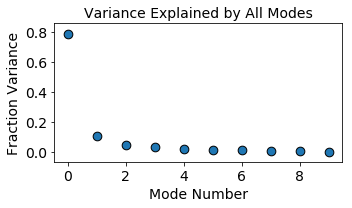

In [58]:
#plot fraction of variance explained by each mode

saveIt = 0

plt.figure(figsize=(5,3))

plt.subplot()
plt.scatter(range(len(fracVar)),fracVar, s = 75, edgecolor = 'k')
plt.xlabel('Mode Number', fontsize = fs)
plt.ylabel('Fraction Variance', fontsize = fs)
plt.xticks(fontsize = fs)
plt.yticks(fontsize = fs)
plt.title('Variance Explained by All Modes', fontsize = fs)

plt.tight_layout()

plt.show()

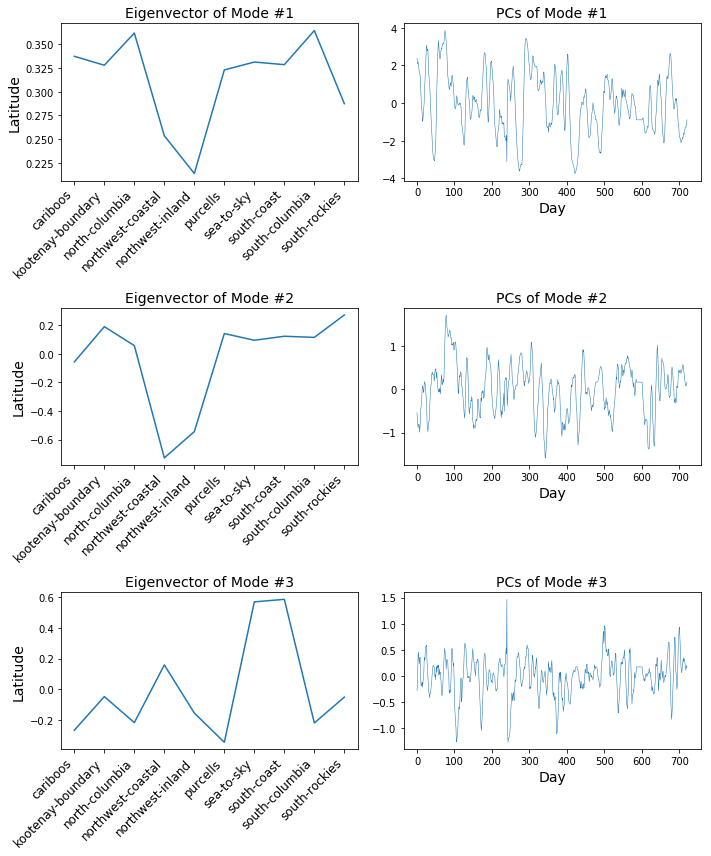

In [59]:
#plot the first n modes (listed regions) and PCs (time series)

saveIt = 0

n = 3

fig, ax = plt.subplots(nrows = n, ncols = 2, figsize=(10,4*n))
for kk in range(n):
    
    ax[kk,0].plot(eigvecs[kk])
    ax[kk,0].set_ylabel('Latitude', fontsize = fs)
    ax[kk,0].set_title('Eigenvector of Mode #' + str(kk+1), fontsize = fs)
    ax[kk,0].set_xticklabels(regions, rotation = 45, ha = 'right', fontsize = fs-2)
    ax[kk,0].set_xticks(range(Nregions))
    
    ax[kk,1].plot(PCs[:,kk], linewidth = 0.5)
    ax[kk,1].set_title('PCs of Mode #' + str(kk+1), fontsize = fs)
    ax[kk,1].set_xlabel('Day', fontsize = fs)
    
plt.tight_layout()
    
plt.show()

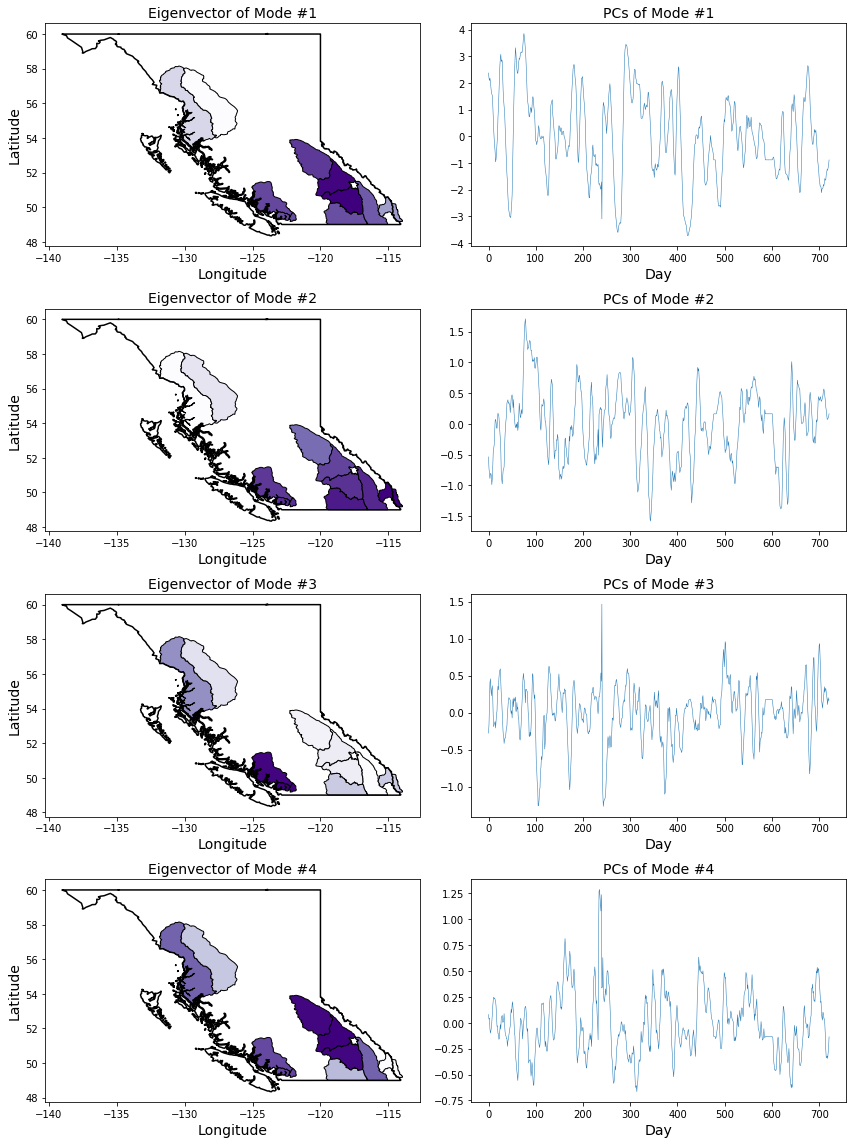

In [60]:
#alternative visualization: plot the first n modes (spatial map) and PCs (time series)

saveIt = 0

n = 4

fig, ax = plt.subplots(nrows = n, ncols = 2, figsize=(12,4*n))
for kk in range(n):
    
    vmin = np.min(eigvecs[kk])
    vmax = np.max(eigvecs[kk])
    norm = Normalize(vmin = vmin, vmax = vmax)
    cmap = cm.get_cmap('Purples')
    mappable = cm.ScalarMappable(norm = norm, cmap = cmap)
    
    #ax[kk,0].plot(eigvecs[kk])
    for pp, poly in enumerate(region_polys):
        ax[kk,0].add_patch(PolygonPatch(poly, alpha = 1, fc = mappable.to_rgba(eigvecs[kk][pp])))
    ax[kk,0].set_xlabel('Longitude', fontsize = fs)
    ax[kk,0].set_ylabel('Latitude', fontsize = fs)
    ax[kk,0].set_title('Eigenvector of Mode #' + str(kk+1), fontsize = fs)
    plot_prov_ax(prov = ['BC'], ax = ax[kk,0])
    
    ax[kk,1].plot(PCs[:,kk], linewidth = 0.5)
    ax[kk,1].set_title('PCs of Mode #' + str(kk+1), fontsize = fs)
    ax[kk,1].set_xlabel('Day', fontsize = fs)
    
plt.tight_layout()
    
plt.show()

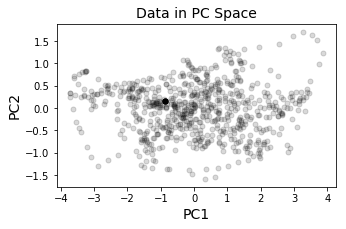

In [61]:
#plot PC1 vs PC2 

plt.figure(figsize=(5,3))
plt.scatter(PCs[:,0],PCs[:,1],s=25,alpha=0.15, color = 'k')
plt.xlabel('PC1', fontsize = fs)
plt.ylabel('PC2', fontsize = fs)
plt.title('Data in PC Space', fontsize = fs)

plt.show()

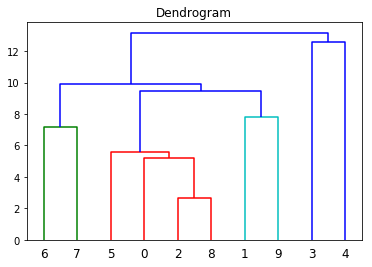

In [62]:
#now try clustering the above-treeline time series -- which regions have similar time series?
#make dendrogram to decide on number of clusters

data = np.copy(above.T)

linked = linkage(data,'single')
labelList = range(1, len(data))

plt.figure()
dendrogram(linked, 
           orientation='top', 
           distance_sort='descending',
           truncate_mode='lastp',
           p=10)
plt.title('Dendrogram')
plt.show()

In [63]:
#now cluster
n_clusters = 3
cluster = AgglomerativeClustering(n_clusters=n_clusters, 
                                  affinity='euclidean', 
                                  linkage='ward')
cn = cluster.fit_predict(data)

#find mean pattern of each cluster
cluster_pattern = np.empty((n_clusters,np.shape(data)[1]))
for cluster_num in range(n_clusters):
    inds = np.argwhere(cn==cluster_num)
    cluster_pattern[cluster_num,:] = np.mean(data[inds,:],axis=0)
    
cluster_obs = np.empty((np.shape(data)))
for ind in range(len(data)):
    cluster_obs[ind] = cluster_pattern[cn[ind]]

#colors of each region
cRegions = np.zeros((len(regions), 3))
for region in range(len(regions)):
    cRegions[region,:] = rgbs3[cluster.labels_[region]]

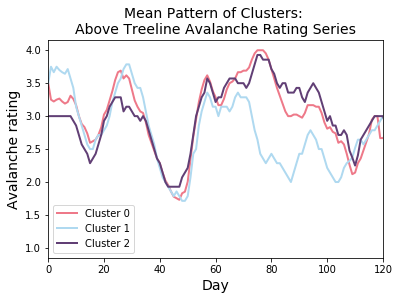

In [81]:
#visualize clusters -- note that one cluster is characterized as having lower avalanche ratings (see day 70 - 100 ish)

saveIt = 0

plt.plot(cluster_pattern[0,:], color = rgbs3[0,:], linewidth = 2)
plt.plot(cluster_pattern[1,:], color = rgbs3[1,:], linewidth = 2)
plt.plot(cluster_pattern[2,:], color = rgbs3[2,:], linewidth = 2)
plt.xlabel('Day', fontsize = fs)
plt.ylabel('Avalanche rating', fontsize = fs)
plt.title('Mean Pattern of Clusters: \nAbove Treeline Avalanche Rating Series', fontsize = fs)
plt.legend(['Cluster ' + str(ii) for ii in range(n_clusters)])
plt.xlim((0,120))

if saveIt:
    plt.savefig('./Figures/above_treeline_clusters_time.png', bbox_inches = 'tight', dpi = 300)

plt.show()

In [70]:
#which regions are in which cluster?
for cc in range(n_clusters):
    inds = np.reshape(np.argwhere(cluster.labels_==cc), (-1,1))
    print([regions[int(ind)] for ind in inds])

['cariboos', 'north-columbia', 'purcells', 'sea-to-sky', 'south-coast', 'south-columbia']
['northwest-coastal', 'northwest-inland']
['kootenay-boundary', 'south-rockies']


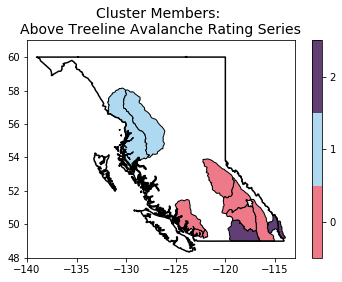

In [82]:
saveIt = 0

cmap = ListedColormap(rgbs3)
bounds = np.arange(n_clusters+1)
norm = BoundaryNorm(bounds, cmap.N)

fig = plt.figure() 
ax = fig.gca() 
for kk, poly in enumerate(region_polys):
    ax.add_patch(PolygonPatch(poly, alpha = 1, fc = cRegions[kk]))
  
plot_prov_ax(prov = ['BC'], ax = ax)

s = ax.scatter([0,1,2,4],[0,1,2,4], c=[0,1,2,4], cmap = cmap, norm = norm) #just for colourmap
ax.set_xlim((-140,-113))
ax.set_ylim((48,61))
ax.set_title('Cluster Members: \nAbove Treeline Avalanche Rating Series', fontsize = fs)
cb = fig.colorbar(s, ax = ax)
cb.set_ticks(np.arange(0.5,n_clusters+0.5,1))
cb.set_ticklabels((np.arange(n_clusters)))

if saveIt:
    plt.savefig('./Figures/above_treeline_clusters_space.png', bbox_inches = 'tight', dpi = 300)

In [83]:
#which clusters are more similar/different?

SE = (cluster_pattern[0] - cluster_pattern[1])**2
AE01 = np.abs(cluster_pattern[0] - cluster_pattern[1]) #absolute error between clusters 0 and 1
AE02 = np.abs(cluster_pattern[0] - cluster_pattern[2]) #absolute error between clusters 0 and 2
AE12 = np.abs(cluster_pattern[1] - cluster_pattern[2]) #absolute error between clusters 1 and 2

print(np.mean(AE01), np.mean(AE02), np.mean(AE12))

0.3622856483313547 0.22694015741107154 0.4174795541485293


In [84]:
#now, calculate the daily rating gradient for each region (slope of rating vs below - treeline - above)

ratings = np.empty((Ndays, Nregions, 3))
ratings[:,:,0] = below
ratings[:,:,1] = treeline
ratings[:,:,2] = above

rating_slope = np.zeros((Ndays, Nregions))
for region in range(Nregions):
    for day in range(Ndays):
        xx = np.arange(3).reshape(-1,1)
        yy = ratings[day, region, :].reshape(-1,1)
        model = LinearRegression().fit(xx, yy)
        slope = model.coef_
        rating_slope[day, region] = slope
    

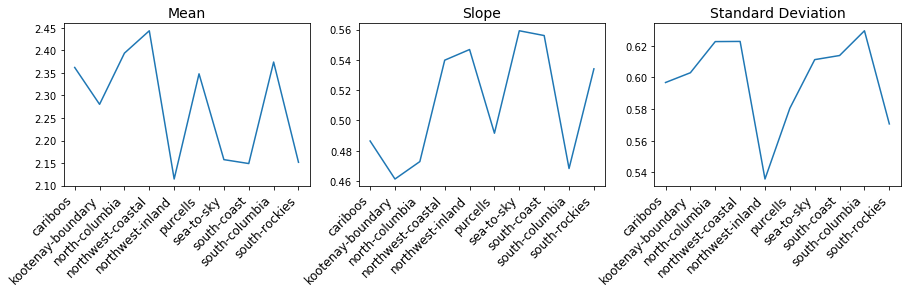

In [85]:
#visualize mean/slope/std dev per region

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15,3))

regions_mean = np.mean(np.mean(ratings, axis = 0), axis = -1)
regions_slope = np.mean(rating_slope, axis = 0)
regions_std = np.mean(np.std(ratings, axis = 0), axis = -1)

ax[0].plot(regions_mean)
ax[0].set_xticklabels(regions, rotation = 45, ha = 'right', fontsize = fs-2)
ax[0].set_xticks(range(Nregions))
ax[0].set_title('Mean', fontsize = fs)

ax[1].plot(regions_slope)
ax[1].set_xticklabels(regions, rotation = 45, ha = 'right', fontsize = fs-2)
ax[1].set_xticks(range(Nregions))
ax[1].set_title('Slope', fontsize = fs)

ax[2].plot(regions_std)
ax[2].set_xticklabels(regions, rotation = 45, ha = 'right', fontsize = fs-2)
ax[2].set_xticks(range(Nregions))
ax[2].set_title('Standard Deviation', fontsize = fs)

plt.show()

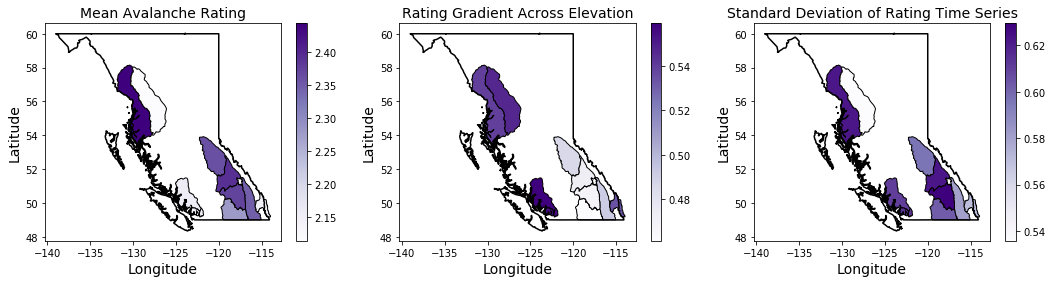

In [87]:
#visualize mean/slope/std dev in space

saveIt = 1

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (18,4))

for kk, poly in enumerate(region_polys):
    
    vmin = np.min(regions_mean)
    vmax = np.max(regions_mean)
    norm = Normalize(vmin = vmin, vmax = vmax)
    cmap = cm.get_cmap('Purples')
    mappable1 = cm.ScalarMappable(norm = norm, cmap = cmap)
    mappable1.set_array([])
    ax[0].add_patch(PolygonPatch(poly, alpha = 1, fc = mappable1.to_rgba(regions_mean[kk])))
    
    vmin = np.min(regions_slope)
    vmax = np.max(regions_slope)
    norm = Normalize(vmin = vmin, vmax = vmax)
    cmap = cm.get_cmap('Purples')
    mappable2 = cm.ScalarMappable(norm = norm, cmap = cmap)
    mappable2.set_array([])
    a = ax[1].add_patch(PolygonPatch(poly, alpha = 1, fc = mappable2.to_rgba(regions_slope[kk])))
    
    vmin = np.min(regions_std)
    vmax = np.max(regions_std)
    norm = Normalize(vmin = vmin, vmax = vmax)
    cmap = cm.get_cmap('Purples')
    mappable3 = cm.ScalarMappable(norm = norm, cmap = cmap)
    mappable3.set_array([])
    a = ax[2].add_patch(PolygonPatch(poly, alpha = 1, fc = mappable3.to_rgba(regions_std[kk])))
    
ax[0].set_xlabel('Longitude', fontsize = fs)
ax[0].set_ylabel('Latitude', fontsize = fs)
ax[0].set_title('Mean Avalanche Rating', fontsize = fs)
plot_prov_ax(prov = ['BC'], ax = ax[0])
fig.colorbar(mappable1, ax = ax[0])

ax[1].set_xlabel('Longitude', fontsize = fs)
ax[1].set_ylabel('Latitude', fontsize = fs)
ax[1].set_title('Rating Gradient Across Elevation', fontsize = fs)
plot_prov_ax(prov = ['BC'], ax = ax[1])
fig.colorbar(mappable2, ax = ax[1])

ax[2].set_xlabel('Longitude', fontsize = fs)
ax[2].set_ylabel('Latitude', fontsize = fs)
ax[2].set_title('Standard Deviation of Rating Time Series', fontsize = fs)
plot_prov_ax(prov = ['BC'], ax = ax[2])
fig.colorbar(mappable3, ax = ax[2])

if saveIt:
    plt.savefig('./Figures/region_characteristics.png', bbox_inches = 'tight', dpi = 300)

plt.show()

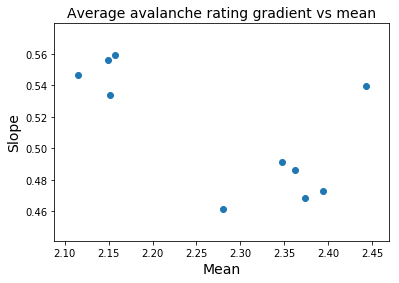

In [88]:
#visualize space of rating slope vs mean -- note the low mean and high slope cluster (e.g. low rating on average, but large difference between below and above treeline ratings)

xx = np.mean(np.mean(ratings, axis = 0), axis = -1)
yy = np.mean(rating_slope, axis = 0)

plt.scatter(xx,yy)
plt.xlabel('Mean', fontsize = fs)
plt.ylabel('Slope', fontsize = fs)
plt.title('Average avalanche rating gradient vs mean', fontsize = fs)

plt.show()

In [89]:
#cluster in the space of slope vs mean

data = np.array([xx,yy]).T

n_clusters = 4
kmeans = KMeans(n_clusters = n_clusters).fit(data)
labels = kmeans.labels_

In [90]:
#find mean pattern of each cluster
cluster_pattern = np.empty((n_clusters,np.shape(data)[1]))
for cluster_num in range(n_clusters):
    inds = np.argwhere(labels==cluster_num)
    cluster_pattern[cluster_num,:] = np.mean(data[inds,:],axis=0)
    
cluster_obs = np.empty((np.shape(data)))
for ind in range(len(data)):
    cluster_obs[ind] = cluster_pattern[labels[ind]]
    
cRegions = np.zeros((len(regions), 3))
for region in range(len(regions)):
    cRegions[region,:] = rgbs4[kmeans.labels_[region]]

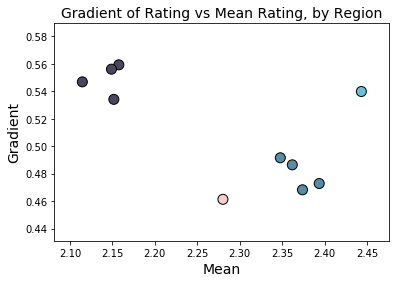

In [107]:
#visualize clusters

saveIt = 0

fig, ax = plt.subplots()

s = ax.scatter(xx,yy, c = cRegions, s = 100, edgecolor = 'k')
ax.set_xlabel('Mean', fontsize = fs)
ax.set_ylabel('Gradient', fontsize = fs)
ax.set_title('Gradient of Rating vs Mean Rating, by Region', fontsize = fs)

if saveIt:
    plt.savefig('./Figures/gradient_vs_mean.png', bbox_inches = 'tight', dpi = 300)

plt.show()

In [99]:
#which regions are in which cluster?

for cc in range(n_clusters):
    inds = np.reshape(np.argwhere(kmeans.labels_==cc),(-1,))
    print([regions[ind] for ind in inds])

['northwest-inland', 'sea-to-sky', 'south-coast', 'south-rockies']
['cariboos', 'north-columbia', 'purcells', 'south-columbia']
['northwest-coastal']
['kootenay-boundary']


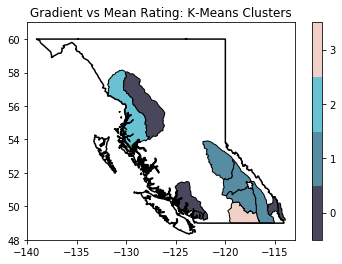

In [108]:
#visualize avalanche rating clusters

saveIt = 0

cmap = ListedColormap(rgbs4)
bounds = np.arange(n_clusters+1)
norm = BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots()

for kk, poly in enumerate(region_polys):
    ax.add_patch(PolygonPatch(poly, alpha = 1, fc = cRegions[kk]))
    
s = ax.scatter([0,1,2,4],[0,1,2,4], c=[0,1,2,4], cmap = cmap, norm = norm) #just for colourmap
plot_prov_ax(prov = ['BC'], ax = ax)
ax.set_xlim((-140,-113))
ax.set_ylim((48,61))
ax.set_title('Gradient vs Mean Rating: K-Means Clusters')
cb = fig.colorbar(s, ax = ax)
cb.set_ticks(np.arange(0.5,n_clusters+0.5,1))
cb.set_ticklabels((np.arange(n_clusters)))

if saveIt:
    plt.savefig('./Figures/gravient_vs_mean_clusters_space.png', bbox_inches = 'tight', dpi = 300)

plt.show()